In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px #plotly express
import seaborn as sns

import re,distance
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
import plotly.graph_objs as go

In [2]:
path = 'datasets/'
train = pd.read_csv(path + '1-train_extracted_features.csv')

In [3]:
print(train.shape)
train.head(2)

(404290, 17)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,num_words_q1,num_words_q2,common_word_q12,total_word_q12,shared_words_q12,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3


<center><h3>1-Text Preprocessing</h3></center>

* `Removing html tags`
* `Removing Punctuations`
* `Stemming`
* `Stopword Removal`
* `Expanding Contractions`

In [4]:
def preprocess(x):
    x = str(x).lower()
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
    .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
    .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
    .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
    .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
    .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
    .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    
    return x

<center><h3>2-Advanced Feature Extraction (NLP and Fuzzy Features)</h3></center>
 
`Token` : will get a token by splitting sentence<br>
`Stop_Word` : stop words as per NLTK<br>
`Word` : token that is not a stop_word<br>

**`New Features`:**
* `common_word_count_min` : Ratio of common_word_count to min lenghth of word count of q1 and q2
    * `common_word_count_min` = common_word_count / (min(len(q1_words), len(q2_words))
* `common_word_count_max` : Ratio of common_word_count to max lenghth of word count of q1 and q2
    * `common_word_count_max` = common_word_count / (max(len(q1_words), len(q2_words))
* `common_stop_count_min` : Ratio of common_stop_count to min lenghth of stop count of q1 and q2
    * `common_stop_count_min` = common_stop_count / (min(len(q1_stops), len(q2_stops))
* `common_stop_count_max` : Ratio of common_stop_count to max lenghth of stop count of q1 and q2
    * `common_stop_count_max` = common_stop_count / (max(len(q1_stops), len(q2_stops))
* `common_token_count_min` : Ratio of common_token_count to min lenghth of token count of q1 and q2
    * `common_token_count_min` = common_token_count / (min(len(q1_tokens), len(q2_tokens))
* `common_token_count_max` : Ratio of common_token_count to max lenghth of token count of q1 and q2
    * `common_token_count_max` = common_token_count / (max(len(q1_tokens), len(q2_tokens))
* `last_word_eq` : Check if First word of both questions is equal or not
    * `last_word_eq` = int(q1_tokens[-1] == q2_tokens[-1])
* `first_word_eq` : Check if First word of both questions is equal or not
   * `first_word_eq` = int(q1_tokens[0] == q2_tokens[0])
* `abs_len_diff` : Abs. length difference
   * `abs_len_diff` = abs(len(q1_tokens) - len(q2_tokens))
* `mean_len` : Average Token Length of both Questions
   * `mean_len` = (len(q1_tokens) + len(q2_tokens))/2
* `longest_substr_ratio` : Ratio of length longest common substring to min lenghth of token count of q1 and q2
    * `longest_substr_ratio` = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

**`Links`**

- [fuzz_ratio-1](https://github.com/seatgeek/fuzzywuzzy#usage) 
- [fuzz_ratio-2](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
- [fuzz_partial_ratio-1](https://github.com/seatgeek/fuzzywuzzy#usage)
- [fuzz_partial_ratio-1](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
- [token_sort_ratio-1](https://github.com/seatgeek/fuzzywuzzy#usage)
- [token_sort_ratio-2](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
- [token_set_ratio-3](https://github.com/seatgeek/fuzzywuzzy#usage) 
- [token_set_ratio-4](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)


In [5]:
SAFE_DIV = 0.0001 # will get results in 4 decemal points
STOP_WORDS = stopwords.words("english")

def get_token_features(q1,q2):
    token_features = [0.0]*10
    
    #Converting Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #getting non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #getting stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #getting common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #getting common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #getting common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1]) #is last word of both question same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0]) #first word of both question is same or not
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2 #average token_length of both Questions
    return token_features

In [6]:
# function to get Longest Common sub string
def getting_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

* [fuzzywuzzy-fuzzy-string-matching-in-python](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
* [when-to-use-which-fuzz-function-to-compare-2-strings](https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings)
* [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) or [fuzzywuzzy updated](https://github.com/seatgeek/thefuzz)

In [7]:
def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess) #using preprocess function
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    print('Token Features...')
    #merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["question1"],x["question2"]),axis=1) #using get_token_features function
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    #computing Fuzzy Features and Merging with Dataset
    print('Fuzzy Features..')
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    """
    Token Sort Approach Involves:
        * Tokenizing string in question
        * Sorting tokens alphabetically then 
        * Joining them back into a string 
    We then compare transformed strings with a simple ratio()
    """     
    df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(lambda x: getting_longest_substr_ratio(x["question1"], 
                                                                                 x["question2"]), axis=1) #using function getting_longest_substr_ratio
    return df


In [9]:
data = extract_features(train)
data.head(3)

Token Features...
Fuzzy Features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [10]:
data.to_csv('datasets/2-train_nlp_features.csv',index=False)

<center><h3>3-Extracted Features Quick Analysis</h3></center>

1. `Plotting Word Cloud` <br>
    1. `word cloud of Duplicates and Non-Duplicates question-pairs`
    2. `will observe most frequent occuring words`
    
2. `Pair plot of features -- ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']`


In [11]:
#segrigating duplicates and non-duplicate points
df_duplicate = data[data['is_duplicate'] == 1]
df_nonduplicate = data[data['is_duplicate'] == 0]

In [12]:
#converting 2d array of q1 and q2 and flatten array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print (f'Number of data points in class 1 (duplicate pairs) ==> {len(p)}')
print (f'Number of data points in class 0 (non duplicate pairs) ==> {len(n)}')

Number of data points in class 1 (duplicate pairs) ==> 298526
Number of data points in class 0 (non duplicate pairs) ==> 510054


In [15]:
#saving np array into a text file
np.savetxt('datasets/train_p.txt',p,delimiter=' ',fmt='%s',encoding='utf-8')
np.savetxt('datasets/train_n.txt',n,delimiter=' ',fmt='%s',encoding='utf-8')

In [24]:
from os import path
# reading text files and removing Stop Words
d = path.dirname('datasets/')
textp_w = open(path.join(d,'train_p.txt'),encoding='utf-8').read()
textn_w = open(path.join(d,'train_n.txt'),encoding='utf-8').read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
#stopwords.remove("good")
#stopwords.remove("love")
#stopwords.remove("best")
#stopwords.remove("!")
print (f'Total number of words in duplicate pair questions ==> {len(textp_w)}')
print (f'Total number of words in non duplicate pair questions ==> {len(textn_w)}')

Total number of words in duplicate pair questions ==> 16109861
Total number of words in non duplicate pair questions ==> 33192952


Word Cloud for Duplicate Question pairs


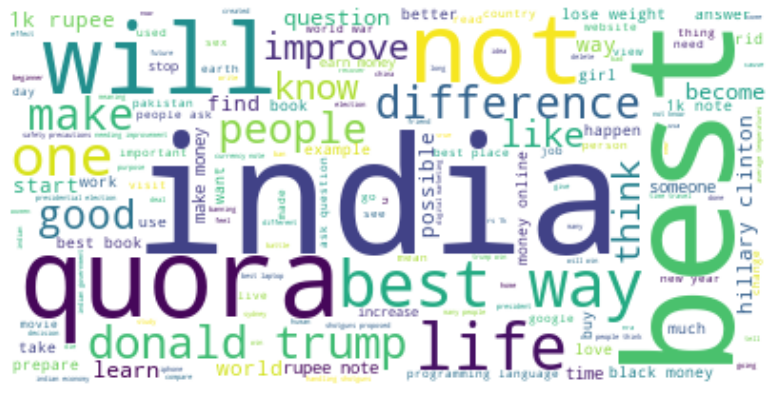

In [33]:
#word Clouds generated from duplicate pair question's text 
plt.figure(figsize=(30,7))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)

print ('Word Cloud for Duplicate Question pairs')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.savefig('output_img/6-wordCloud_duplicatePairQuestions.png')
plt.show()

Word Cloud for Non-Duplicate Question pairs


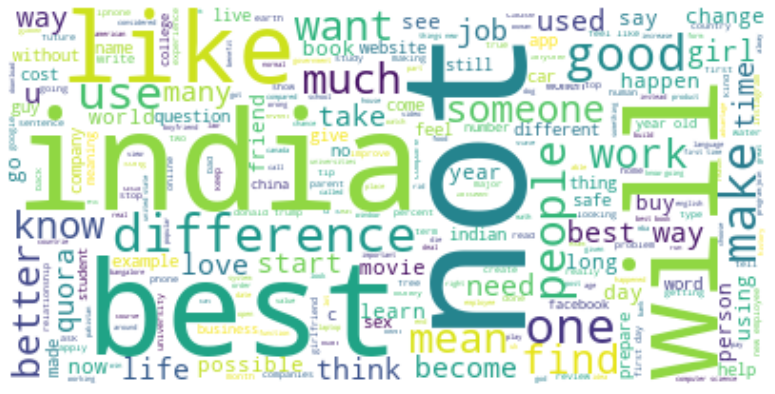

In [32]:
# Word Clouds generated from non duplicate pair question's text
plt.figure(figsize=(30,7))
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)

print ('Word Cloud for Non-Duplicate Question pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('output_img/7-wordCloud_nonDuplicatePairQuestions.png')
plt.show()

<center><h3>4-Visualization</h3></center>

* Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

In [35]:
from sklearn.preprocessing import MinMaxScaler


df_subsampled = data[0:5000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min','cwc_max','csc_min','csc_max',
                                                'ctc_min','ctc_max','last_word_eq','first_word_eq',
                                                'abs_len_diff','mean_len','token_set_ratio','token_sort_ratio',
                                                'fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']])
y = df_subsampled['is_duplicate'].values

In [37]:
## TSNE

tsne2d = TSNE(n_components=2,init='random', random_state=108,method='barnes_hut',
              n_iter=1000,verbose=2,angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.213s
[t-SNE] Iteration 50: error = 80.9720154, gradient norm = 0.0451379 (50 iterations in 2.474s)
[t-SNE] Iteration 100: error = 70.4389801, gradient norm = 0.0098959 (50 iterations in 2.213s)
[t-SNE] Iteration 150: error = 68.6479645, gradient norm = 0.0059423 (50 iterations in 2.076s)
[t-SNE] Iteration 200: error = 67.8050308, gradient norm = 0.0040715 (50 iterations in 2.095s)
[t-SNE] Iteration 250: error = 67.3068771, gradient norm = 0.0031636

In [55]:
data1 = pd.DataFrame({'x':tsne2d[:,0],'y':tsne2d[:,1],'label':y})

,x,y,label
0,-23.209225,-50.464333,0
1,-15.731110,-13.398643,0
2,-4.285475,15.736924,0
3,83.609055,-8.091357,0
4,-22.560377,16.723259,0


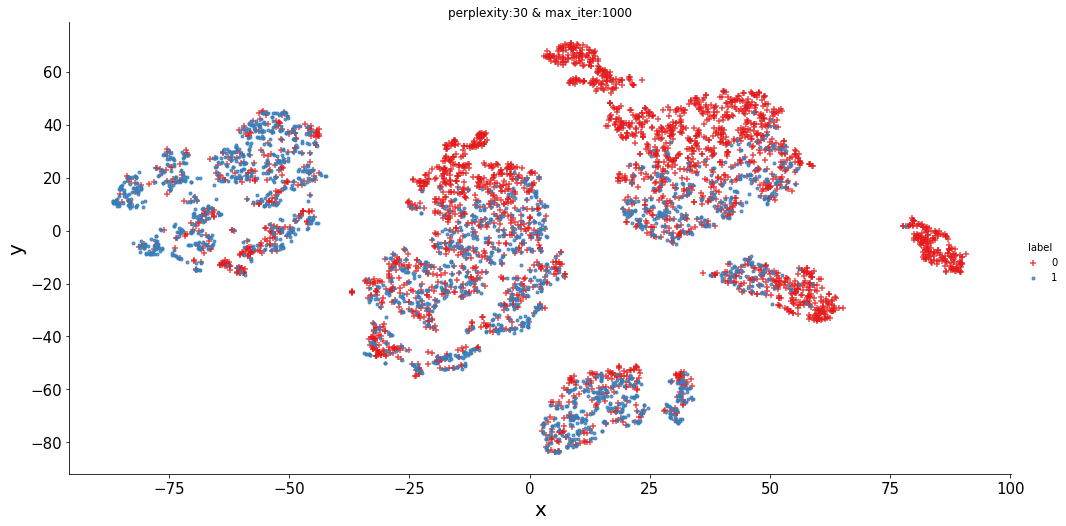

In [72]:
#drawing plot in appropriate place in grid
sns.lmplot(x='x',y='y',data=data1,hue='label',fit_reg=False,height=7,palette="Set1",markers=['+','.'],aspect=2)

plt.title(f'perplexity:{30} & max_iter:{1000}')
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('output_img/8-TSNE_dim_reduction_15advanced_feature.png')

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.197s
[t-SNE] Iteration 50: error = 82.3574753, gradient norm = 0.0374091 (50 iterations in 6.507s)
[t-SNE] Iteration 100: error = 69.2868958, gradient norm = 0.0037571 (50 iterations in 3.477s)
[t-SNE] Iteration 150: error = 67.7186813, gradient norm = 0.0019373 (50 iterations in 3.575s)
[t-SNE] Iteration 200: error = 67.1032715, gradient norm = 0.0012593 (50 iterations in 2.947s)
[t-SNE] Iteration 250: error = 66.7508926, gradient norm = 0.0009164

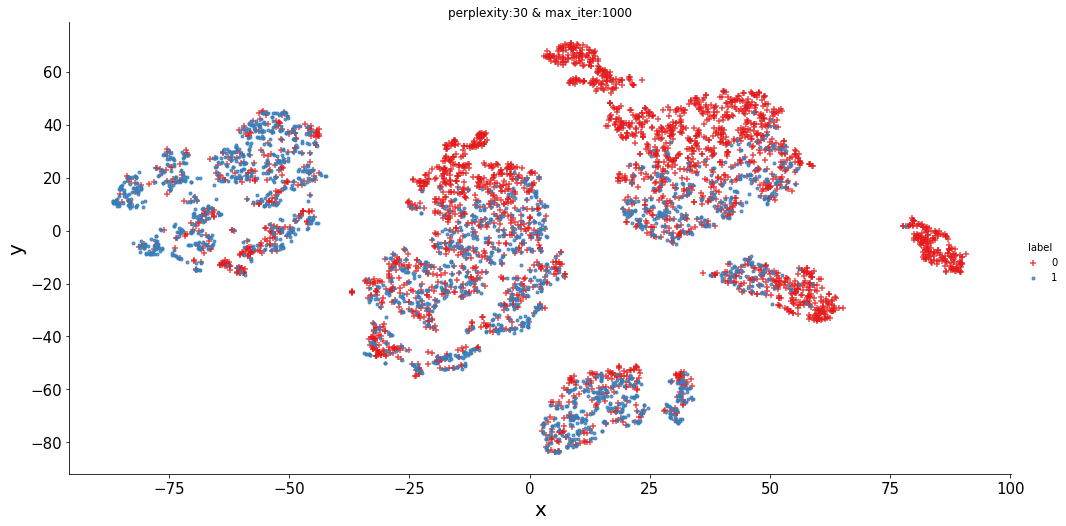

In [73]:
##go
tsne3d = TSNE(n_components=3,init='random',random_state=108,method='barnes_hut',
              n_iter=1000,verbose=2,angle=0.5).fit_transform(X)

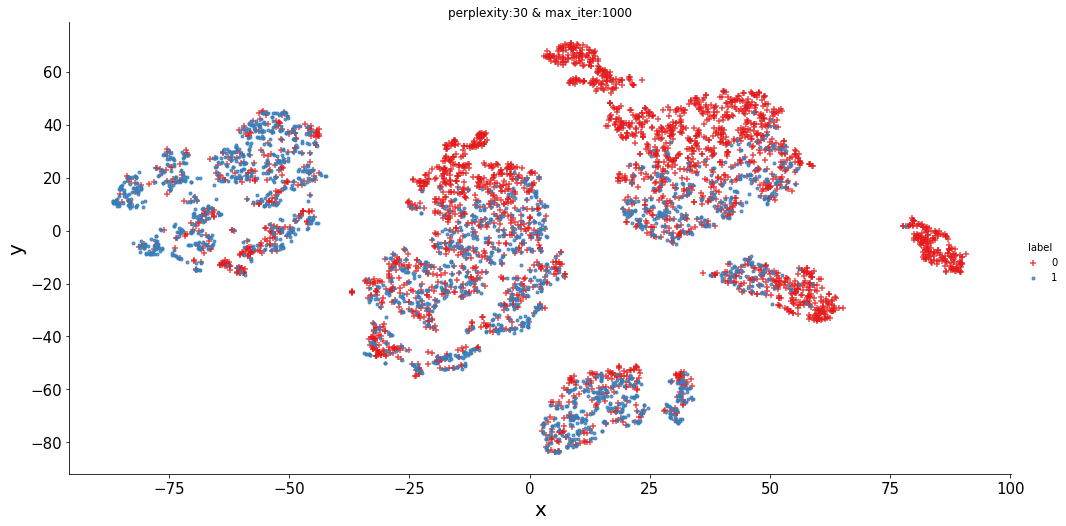

In [74]:
data2 = pd.DataFrame({'x':tsne3d[:,0],'y':tsne3d[:,1],'label':y})
#drawing plot in appropriate place in grid
sns.lmplot(x='x',y='y',data=data1,hue='label',fit_reg=False,height=7,palette="Set1",markers=['+','.'],aspect=2)

plt.title(f'perplexity:{30} & max_iter:{1000}')
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [77]:
trace1 = go.Scatter3d(x=tsne3d[:,0],y=tsne3d[:,1],z=tsne3d[:,2],mode='markers',
                      marker=dict(sizemode='diameter',color=y,colorscale='Portland',colorbar = dict(title='duplicate'),
                                  line=dict(color='rgb(255, 255, 255)'),opacity=0.75))
Data = [trace1]


In [88]:
import plotly.offline as py

layout = dict(height=800, width=900, title='=')
fig = dict(data=Data, layout=layout)
py.iplot(fig, filename='3DBubble')

plt.show()